<a href="https://colab.research.google.com/github/ejdam87/neural-network/blob/master/nn_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

Third-party imports

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d

Standard imports

In [3]:
import random
from typing import Callable, Any

# Modules

In [20]:
class Module:
    def forward(self, x: NDArray) -> NDArray:
        raise NotImplementedError()

In [21]:
class Sequential(Module):
    def __init__(self, layers: list[Module]) -> None:
        self.layers = layers

    def forward(self, x: NDArray) -> NDArray:
        res = x
        for layer in self.layers:
            res = layer.forward(res)

        return res

## Special

In [22]:
class FlattenLayer(Module):
    def forward(self, x: NDArray) -> NDArray:
        return x.flatten()

## Activations

In [23]:
class Activation(Module):
    def __init__(self, in_count: int) -> None:
        self.in_count = in_count

In [24]:
class StepActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return (x >= 0).astype(int)

In [25]:
class SigmoidActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return 1 / ( 1 + np.e ** (-x) )

In [26]:
class ReLUActivation(Activation):
    def forward(self, x: NDArray) -> NDArray:
        return (x + np.abs(x)) / 2  # same as max(0, elem) for elem in x

## Neural layers

In [27]:
class Dense(Module):
    def __init__(self,
                 in_count: int,
                 out_count: int,
                 ) -> None:

        self.in_count = in_count
        self.out_count = out_count
        self.weights = np.random.rand(self.out_count, self.in_count)
        self.biases = np.random.rand(self.out_count)

    def forward(self, x: NDArray) -> NDArray:
        return np.dot( self.weights, x ) + self.biases

    def set_weights(self, weights: NDArray) -> None:
        self.weights = weights

    def set_biases(self, biases: NDArray) -> None:
        self.biases = biases

# Data module

In [15]:
class Dataset:
    def __init__(self, x: NDArray, y: NDArray) -> None:
        self.x = x
        self.y = y

    def __iter__(self) -> tuple[NDArray, NDArray]:
        for x_i, y_i in zip( self.x, self.y ):
            yield x_i, y_i

# Training

## Cost functions

In [12]:
class Cost:
    def forward(self, y_pred: NDArray, y: NDArray) -> float:
        raise NotImplementedError()

In [13]:
class MSE(Cost):
    def forward(self, y: NDArray, y_pred: NDArray) -> float:
        return ( (y_pred - y) ** 2 ) / len(y)

In [14]:
class BCE(Cost):
    def forward(self, y: NDArray, y_pred: NDArray) -> float:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  ## avoid log of 0

        loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        mean_loss = np.mean(loss)

        return mean_loss

## Optimizers

In [16]:
class Optimizer:
    def __init__(self, lr: float, model: Module) -> None:
        self.lr = lr
        self.model = model

    def step(self, w: NDArray) -> NDArray:
        raise NotImplementedError()

In [50]:
class MSElinearOptimizer(Optimizer):
    def calc_grad(self, w: NDArray, data: Dataset) -> NDArray:
        res = np.zeros_like(w)
        for x, y in data:
            res += (self.model.forward(x) - y)[0] * np.insert(np.array(x), 0, 1)
        return res

    def step(self, w: NDArray, data: Dataset) -> NDArray:
        return w - self.lr * self.calc_grad(w, data)

## Trainer

In [55]:
class Trainer:
    def __init__(self,
                 model: Module,
                 data: Dataset,
                 optimizer: Optimizer) -> None:
        self.epochs = 1000
        self.model = model
        self.data = data
        self.optimizer = optimizer

    def train(self) -> None:
        for _ in range(self.epochs):
            w = self.model.weights[0]
            b = self.model.biases[0]
            w = np.insert(w, 0, b)

            new_w = self.optimizer.step(w, self.data)
            new_b = new_w[0]
            new_w = np.array( [new_w[1:]] )
            self.model.weights = new_w
            self.model.biases = [new_b]


# Showcase

## Basic model creation

In [ ]:
model = Sequential( [
    Dense(3, 2),
    StepActivation(2),
    Dense(2, 1),
    SigmoidActivation(1)
] )

print( model.forward( np.array([1, 2, 3]) ) )

## Activations

Activations plots on 1D inputs

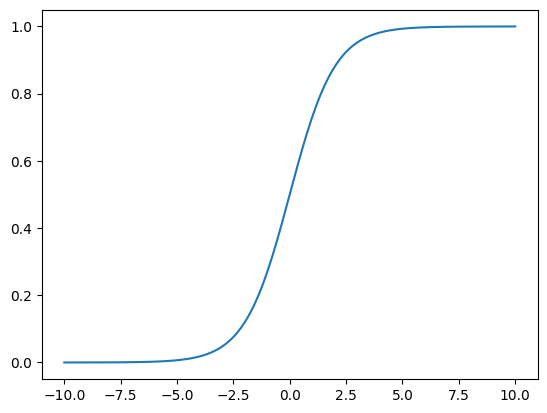

In [ ]:
sigmoid = SigmoidActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)

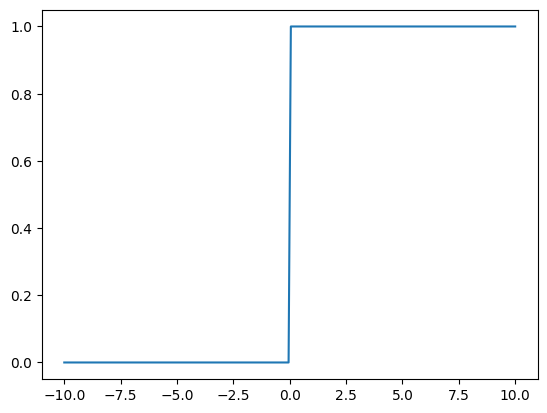

In [ ]:
sigmoid = StepActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)

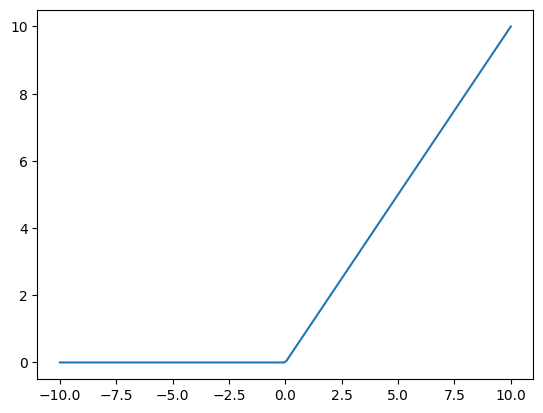

In [ ]:
sigmoid = ReLUActivation(200)
x = np.linspace(-10, 10, 200)
y = sigmoid.forward(x)

plt.plot(x, y)

## Training

Trying to fit function f(x) = 3x - 2

In [57]:
linear = Dense(1, 1)    ## model
mse = MSE() ## cost function

## data
x = np.linspace(-10, 10, 200)
y = 3 * x - 2
data = Dataset(x, y)

## optimizer
lr = 0.001
optimizer = MSElinearOptimizer(lr, linear)

## trainer
trainer = Trainer(linear, data, optimizer)
trainer.train()

linear.weights, linear.biases

<ipython-input-50-f6a8e689f80d>:5: RuntimeWarning: overflow encountered in add
  res += (self.model.forward(x) - y)[0] * np.insert(np.array(x), 0, 1)
<ipython-input-50-f6a8e689f80d>:5: RuntimeWarning: invalid value encountered in add
  res += (self.model.forward(x) - y)[0] * np.insert(np.array(x), 0, 1)
<ipython-input-50-f6a8e689f80d>:9: RuntimeWarning: invalid value encountered in subtract
  return w - self.lr * self.calc_grad(w, data)


(array([[nan]]), [nan])

# Convolution

In [ ]:
def convolve_rgb(im: NDArray, kernel: NDArray) -> NDArray:
    res = np.zeros_like(im)
    for i in range(3):   #3 color channels
        res[..., i] = convolve2d( im[..., i], kernel[..., i], mode="same").astype(np.int8)

    return res

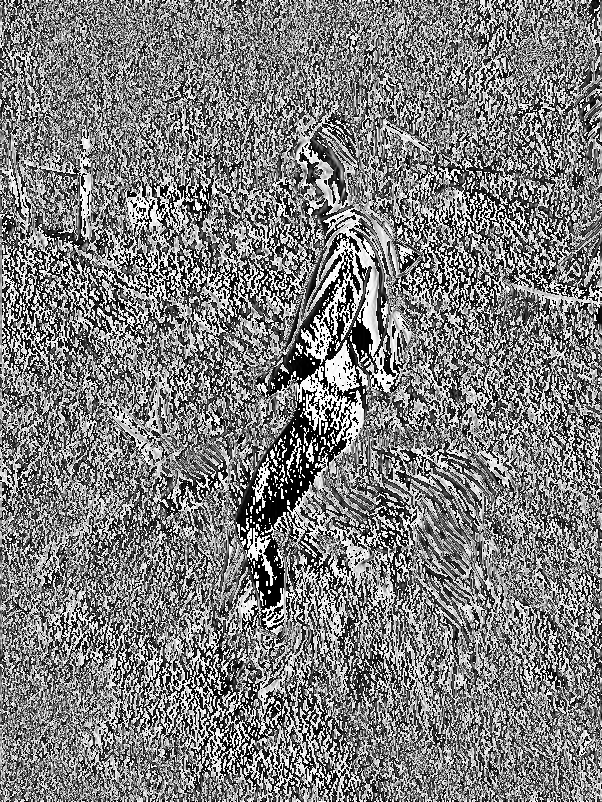

In [ ]:
WIDTH, HEIGHT = 600, 800
eli = np.array( Image.open("eli.jpg").resize((WIDTH, HEIGHT)) )

eli_gray = np.mean(eli, axis=-1).astype(np.int8)

blur_kernel = np.array( [
    [0.0030, 0.0133, 0.0219, 0.0133, 0.0030],
    [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
    [0.0219, 0.0983, 0.1621, 0.0983, 0.0219],
    [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
    [0.0030, 0.0133, 0.0219, 0.0133, 0.0030]
] )

vertical_edge_kernel = np.array (
    [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ]
).astype(np.int8)

kernel = np.stack( [vertical_edge_kernel, vertical_edge_kernel, vertical_edge_kernel], axis=-1 )

Image.fromarray(convolve2d(eli_gray, vertical_edge_kernel), mode="L")